In [1]:
import numpy as np
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt
import scipy.stats as scpstat
import matplotlib.dates as dates
import datetime
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices
from itertools import groupby


# for feature selection
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [2]:
regression_infile = "regression_thread_data.p"
thread_infile = 'clean_5_thread_data.p'
FSS_outfile = "weekly_FSS.xlsx"
FSS_metrics_pickle_outfile = "weekly_FSS_metrics.p"

In [3]:
# set data collection window size in days
collection_window = 7
# set modelling window size in days
model_window = 7
# set roll step
step = 7

In [4]:
### REGRESSION PARAMS ####
SCORING_METHOD = 'roc_auc'
X_COLS = [
    'sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'hour',
    'time_in_secs', 'num_dayofweek','activity_ratio', 'mean_author_sentiment_sign',
    'mean_author_sentiment_magnitude',
    ]
Y_COL = 'success'

In [5]:
params_dict = {
    'regression_infile': regression_infile,
    'thread_infile': thread_infile,
    'FSS_outfile': FSS_outfile,
    'FSS metrics pickle out': FSS_metrics_pickle_outfile,
    'collection window': collection_window,
    'model window': model_window,
    'step': step,
    'performance scoring method': SCORING_METHOD,
    'x cols': X_COLS,
    'y col': Y_COL
}

In [13]:
pd.DataFrame.from_dict(params_dict, orient='index').reset_index().rename(columns={
    'index': 'parameter',
    0: 'input'
    }).to_csv('out.csv')

In [89]:
column_functions = {
            'time_in_secs': float_seconds,
            'num_dayofweek': get_dayofweek,
            'hour': get_hour
        }

In [4]:
def get_date(timestamp):
    return timestamp.date()

def get_score(row):
    if row.thread_id == row.id:
        return row.subject_sentiment_score
    else:
        return row.body_sentiment_score

In [39]:
def float_seconds(time_row):
    hours = time_row.hour
    minutes = time_row.minute
    seconds = time_row.second
    return hours*60*60 + minutes*60 + seconds

def get_dayofweek(timestamp):
    return timestamp.dayofweek

def get_hour(timestamp):
    return timestamp.hour

In [88]:
def logit_forward_sequential_selection(X, y, name='',):
    
    max_k = len(X.columns)
    k=(1, max_k)

    sfs = SequentialFeatureSelector(
        linear_model.LogisticRegression(),
        k_features = k,
        forward=True,
        scoring=SCORING_METHOD,
        cv=None,
        )
    
    selected_features = sfs.fit(X, y)
    print(f'selected features: {selected_features.k_feature_names_}')
    metric_df = pd.DataFrame.from_dict(selected_features.get_metric_dict(), orient='index')
    display(metric_df)
    
    results = {
        'name': name,
        'metric_df': metric_df,
        'selected_features': selected_features.k_feature_names_,
        'plot_data' : selected_features.get_metric_dict(),
    }
    return results

In [150]:
def get_FSS_metrics_time_periods(subreddit_thread_data, subreddit_regression_data):
    FSS_metrics = {}

    # only use wanted cols
    all_data = subreddit_thread_data[['thread_id', 'id', 'timestamp', 'author', 'sentiment_score']]
    
    # get array of dates in dataset
    date_array = all_data.timestamp.apply(get_date).unique()

    # start time period counter (start on 1 as period 0 is collection data not modelled)
    period_counter = 1

    # iterate through date array windows
    for i in range(0, len(date_array) - (collection_window + model_window), step):
        print(f"Period {period_counter}")

        collection_dates = date_array[i:i+collection_window]
        model_dates = date_array[i+collection_window:i+collection_window+model_window]

        # get thread data for collection time period
        thread_collection_data = all_data[all_data.timestamp.apply(get_date).isin(collection_dates)]

        # make dict for activity breakdown
        activity_type = {
            'all_activity': thread_collection_data,
            'post': thread_collection_data[thread_collection_data.thread_id == thread_collection_data.id],
            'comment': thread_collection_data[thread_collection_data.thread_id != thread_collection_data.id]
        }

        # get activity counts and sentiment means

        #author_mean_sentiment = {}
        started = False
        for key in activity_type:
            author_activity_count = activity_type[key][['author', 'id']].groupby('author').count().rename(columns={'id': f'author_{key}_count'})
            if not started:
                author_activity = author_activity_count
                started = True
            else:
                author_activity = pd.concat((author_activity, author_activity_count), axis=1).fillna(0).astype(int)
            #author_mean_sentiment[key] = activity_type[key][['author', 'sentiment_score']].groupby('author').mean().rename(columns={'sentiment_score': f'author_{key}_mean_sentiment'})

        author_activity['activity_ratio'] = (
            (author_activity.author_comment_count - author_activity.author_post_count)/
            author_activity.author_all_activity_count
        )

        author_mean_sentiment = activity_type['all_activity'][['author', 'sentiment_score']].groupby('author').mean().rename(columns={'sentiment_score': f'mean_author_sentiment'})

        # combine to form author info df
        author_data = pd.concat((author_activity[['author_all_activity_count', 'activity_ratio']], author_mean_sentiment), axis=1)

        # combine collected author info data from collection period with model data in model time period
        regression_model_data = subreddit_regression_data[subreddit_regression_data.timestamp.apply(get_date).isin(model_dates)].merge(author_data.reset_index(), on='author')

        # separate mean author sentiment into magnitude and sign
        col = 'mean_author_sentiment'
        regression_model_data[f'{col}_sign'] = np.sign(regression_model_data[col])
        regression_model_data[f'{col}_magnitude'] = np.absolute(regression_model_data[col])

        # make other required cols
        for col in column_functions:
            if col in X_COLS:
                regression_model_data[col] = regression_model_data.timestamp.apply(column_functions[col])
        
        # Run forward sequential selection
        FSS_metrics[period_counter] = (
            logit_forward_sequential_selection(
            regression_model_data[X_COLS],
            regression_model_data[Y_COL],
            name = f"{subreddit}_period_{period_counter}"
            )
        )

        # add another week to counter
        period_counter += 1
    
    i = 0
    for period in FSS_metrics:
        df = FSS_metrics[period]['metric_df'][['feature_idx', 'cv_scores', 'avg_score', 'feature_names']].reset_index().rename(columns={'index': 'number_features'})
        df.loc[:,'period'] = period
        if i == 0:
            FSS_metrics_df = df
            i += 1
        else:
            FSS_metrics_df = pd.concat((FSS_metrics_df, df))
    
        FSS_metrics[period].pop('metric_df')
    FSS_metrics_df.set_index('period', inplace=True)

    return FSS_metrics, FSS_metrics_df

In [ ]:
regression_data = pickle.load(open(regression_infile, 'rb'))
thread_data = pickle.load(open(thread_infile, 'rb'))

if remove:
    regression_data.pop(remove)

In [60]:
import warnings
warnings.filterwarnings('ignore')

In [151]:
FSS_metrics = {}
FSS_metrics_dfs = {}

# iterate through all subreddits
for subreddit in regression_data:
    print(f"###{subreddit}###")

    thread_data[subreddit]['sentiment_score'] = thread_data[subreddit].apply(get_score, axis=1)

    FSS_metrics[subreddit], FSS_metrics_dfs[subreddit] = get_FSS_metrics_time_periods(thread_data[subreddit], regression_data[subreddit])



###books###
Period 1
selected features: ('activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.6812734962406015],0.681273,"(activity_ratio,)",NaN,0.0,NaN
2,"(6, 7)",[0.7394854323308271],0.739485,"(activity_ratio, mean_author_sentiment_sign)",NaN,0.0,NaN
3,"(6, 7, 8)",[0.7670935150375939],0.767094,"(activity_ratio, mean_author_sentiment_sign, m...",NaN,0.0,NaN
4,"(3, 6, 7, 8)",[0.7629816729323308],0.762982,"(hour, activity_ratio, mean_author_sentiment_s...",NaN,0.0,NaN
5,"(0, 3, 6, 7, 8)",[0.7622767857142857],0.762277,"(sentiment_sign, hour, activity_ratio, mean_au...",NaN,0.0,NaN
6,"(0, 1, 3, 6, 7, 8)",[0.7573425751879699],0.757343,"(sentiment_sign, sentiment_magnitude, hour, ac...",NaN,0.0,NaN
7,"(0, 1, 3, 5, 6, 7, 8)",[0.7545230263157895],0.754523,"(sentiment_sign, sentiment_magnitude, hour, nu...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.7525258458646616],0.752526,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.46921992481203006],0.469220,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 2
selected features: ('sentiment_sign', 'sentiment_magnitude', 'activity_ratio', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)",[0.7164892164892165],0.716489,"(mean_author_sentiment_magnitude,)",NaN,0.0,NaN
2,"(6, 8)",[0.7440622440622441],0.744062,"(activity_ratio, mean_author_sentiment_magnitude)",NaN,0.0,NaN
3,"(0, 6, 8)",[0.7502047502047503],0.750205,"(sentiment_sign, activity_ratio, mean_author_s...",NaN,0.0,NaN
4,"(0, 1, 6, 8)",[0.7684957684957685],0.768496,"(sentiment_sign, sentiment_magnitude, activity...",NaN,0.0,NaN
5,"(0, 1, 3, 6, 8)",[0.7651515151515151],0.765152,"(sentiment_sign, sentiment_magnitude, hour, ac...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 6, 8)",[0.7637865137865137],0.763787,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 5, 6, 8)",[0.761875511875512],0.761876,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.7625580125580126],0.762558,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.47420147420147424],0.474201,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 3
selected features: ('sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'hour', 'num_dayofweek', 'activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.6628384687208216],0.662838,"(activity_ratio,)",NaN,0.0,NaN
2,"(6, 7)",[0.7092436974789916],0.709244,"(activity_ratio, mean_author_sentiment_sign)",NaN,0.0,NaN
3,"(6, 7, 8)",[0.7168067226890756],0.716807,"(activity_ratio, mean_author_sentiment_sign, m...",NaN,0.0,NaN
4,"(1, 6, 7, 8)",[0.7175536881419233],0.717554,"(sentiment_magnitude, activity_ratio, mean_aut...",NaN,0.0,NaN
5,"(0, 1, 6, 7, 8)",[0.7173669467787114],0.717367,"(sentiment_sign, sentiment_magnitude, activity...",NaN,0.0,NaN
6,"(0, 1, 2, 6, 7, 8)",[0.7141923436041082],0.714192,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 6, 7, 8)",[0.7202614379084967],0.720261,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.7214752567693743],0.721475,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.48888888888888893],0.488889,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


###conspiracy###
Period 1
selected features: ('sentiment_sign', 'hour', 'time_in_secs', 'activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.6607574875832207],0.660757,"(activity_ratio,)",NaN,0.0,NaN
2,"(6, 7)",[0.6680574923413085],0.668057,"(activity_ratio, mean_author_sentiment_sign)",NaN,0.0,NaN
3,"(0, 6, 7)",[0.6712746917308092],0.671275,"(sentiment_sign, activity_ratio, mean_author_s...",NaN,0.0,NaN
4,"(0, 3, 6, 7)",[0.6738769997694158],0.673877,"(sentiment_sign, hour, activity_ratio, mean_au...",NaN,0.0,NaN
5,"(0, 3, 4, 6, 7)",[0.6784886849011231],0.678489,"(sentiment_sign, hour, time_in_secs, activity_...",NaN,0.0,NaN
6,"(0, 3, 4, 6, 7, 8)",[0.6787522097657923],0.678752,"(sentiment_sign, hour, time_in_secs, activity_...",NaN,0.0,NaN
7,"(0, 3, 4, 5, 6, 7, 8)",[0.6782434603742785],0.678243,"(sentiment_sign, hour, time_in_secs, num_dayof...",NaN,0.0,NaN
8,"(0, 1, 3, 4, 5, 6, 7, 8)",[0.677705430442246],0.677705,"(sentiment_sign, sentiment_magnitude, hour, ti...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5535376383048031],0.553538,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 2
selected features: ('sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'hour', 'num_dayofweek', 'activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.7039767699944512],0.703977,"(activity_ratio,)",NaN,0.0,NaN
2,"(1, 6)",[0.7263950750588622],0.726395,"(sentiment_magnitude, activity_ratio)",NaN,0.0,NaN
3,"(1, 2, 6)",[0.7370596571737076],0.737060,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
4,"(1, 2, 6, 7)",[0.745626565288463],0.745627,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
5,"(1, 2, 3, 6, 7)",[0.753541113660563],0.753541,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
6,"(1, 2, 3, 6, 7, 8)",[0.7544915343201212],0.754492,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
7,"(1, 2, 3, 5, 6, 7, 8)",[0.7548214633853721],0.754821,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.754892698069915],0.754893,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.580442704818464],0.580443,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 3
selected features: ('sentiment_magnitude', 'author_all_activity_count', 'hour', 'activity_ratio', 'mean_author_sentiment_sign')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(6,)",[0.6922669064167732],0.692267,"(activity_ratio,)",NaN,0.0,NaN
2,"(2, 6)",[0.7012921147573106],0.701292,"(author_all_activity_count, activity_ratio)",NaN,0.0,NaN
3,"(2, 6, 7)",[0.7037703009555425],0.703770,"(author_all_activity_count, activity_ratio, me...",NaN,0.0,NaN
4,"(1, 2, 6, 7)",[0.7063320538976682],0.706332,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
5,"(1, 2, 3, 6, 7)",[0.7066259783072258],0.706626,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 6, 7)",[0.7063262906739515],0.706326,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 5, 6, 7)",[0.7059372730730661],0.705937,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.7038221699689939],0.703822,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.564940004841108],0.564940,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


###crypto###
Period 1
selected features: ('author_all_activity_count',)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6495829318797609],0.649583,"(author_all_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.6367262148739214],0.636726,"(author_all_activity_count, hour)",NaN,0.0,NaN
3,"(1, 2, 3)",[0.6144987730159321],0.614499,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
4,"(0, 1, 2, 3)",[0.6142964936468309],0.614296,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
5,"(0, 1, 2, 3, 6)",[0.6092860869056047],0.609286,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
6,"(0, 1, 2, 3, 6, 8)",[0.6277926530003886],0.627793,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 5, 6, 8)",[0.6326293922569587],0.632629,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.6348837425941797],0.634884,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5804406496361633],0.580441,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 2
selected features: ('author_all_activity_count',)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6716957728582558],0.671696,"(author_all_activity_count,)",NaN,0.0,NaN
2,"(2, 3)",[0.6670458413063373],0.667046,"(author_all_activity_count, hour)",NaN,0.0,NaN
3,"(2, 3, 5)",[0.6581105304159072],0.658111,"(author_all_activity_count, hour, num_dayofweek)",NaN,0.0,NaN
4,"(2, 3, 5, 7)",[0.6518042309234062],0.651804,"(author_all_activity_count, hour, num_dayofwee...",NaN,0.0,NaN
5,"(2, 3, 5, 7, 8)",[0.6414810500918944],0.641481,"(author_all_activity_count, hour, num_dayofwee...",NaN,0.0,NaN
6,"(1, 2, 3, 5, 7, 8)",[0.6458518949908105],0.645852,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 5, 7, 8)",[0.6467095759244273],0.646710,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.644160735760152],0.644161,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5821339162134975],0.582134,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 3
selected features: ('author_all_activity_count',)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6801785322309212],0.680179,"(author_all_activity_count,)",NaN,0.0,NaN
2,"(1, 2)",[0.655927505999107],0.655928,"(sentiment_magnitude, author_all_activity_count)",NaN,0.0,NaN
3,"(1, 2, 5)",[0.640152878302122],0.640153,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
4,"(1, 2, 5, 8)",[0.6335952980738648],0.633595,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
5,"(1, 2, 5, 6, 8)",[0.6503054430230422],0.650305,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
6,"(1, 2, 3, 5, 6, 8)",[0.6536816672963179],0.653682,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
7,"(1, 2, 3, 5, 6, 7, 8)",[0.6559558776316556],0.655956,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.6587333111337752],0.658733,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.6161960211025217],0.616196,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


###politics###
Period 1
selected features: ('sentiment_magnitude', 'author_all_activity_count', 'hour', 'num_dayofweek', 'activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.5873173910766913],0.587317,"(author_all_activity_count,)",NaN,0.0,NaN
2,"(1, 2)",[0.5846365399863362],0.584637,"(sentiment_magnitude, author_all_activity_count)",NaN,0.0,NaN
3,"(1, 2, 7)",[0.5822100136637227],0.582210,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
4,"(1, 2, 3, 7)",[0.5778564941330767],0.577856,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
5,"(1, 2, 3, 6, 7)",[0.5807460099685335],0.580746,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
6,"(1, 2, 3, 6, 7, 8)",[0.5879835910657205],0.587984,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
7,"(1, 2, 3, 5, 6, 7, 8)",[0.5909362205843485],0.590936,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.5907846698266104],0.590785,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5687713963177763],0.568771,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 2
selected features: ('sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'hour', 'num_dayofweek', 'activity_ratio', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.5813084503251555],0.581308,"(author_all_activity_count,)",NaN,0.0,NaN
2,"(2, 5)",[0.5810197544046982],0.581020,"(author_all_activity_count, num_dayofweek)",NaN,0.0,NaN
3,"(1, 2, 5)",[0.5767609767358406],0.576761,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
4,"(1, 2, 3, 5)",[0.5744585207828241],0.574459,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
5,"(1, 2, 3, 5, 8)",[0.5869994934487497],0.586999,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
6,"(1, 2, 3, 5, 6, 8)",[0.5990545653068191],0.599055,"(sentiment_magnitude, author_all_activity_coun...",NaN,0.0,NaN
7,"(0, 1, 2, 3, 5, 6, 8)",[0.6004229648236807],0.600423,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.6003067206112749],0.600307,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5733730733547477],0.573373,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 3
selected features: ('author_all_activity_count',)


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(2,)",[0.6078839367501718],0.607884,"(author_all_activity_count,)",NaN,0.0,NaN
2,"(1, 2)",[0.606437596083367],0.606438,"(sentiment_magnitude, author_all_activity_count)",NaN,0.0,NaN
3,"(0, 1, 2)",[0.6033679660258451],0.603368,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
4,"(0, 1, 2, 5)",[0.594074274804097],0.594074,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
5,"(0, 1, 2, 5, 7)",[0.5882307688432549],0.588231,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
6,"(0, 1, 2, 5, 7, 8)",[0.5873812890263245],0.587381,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
7,"(0, 1, 2, 5, 6, 7, 8)",[0.5923655546534365],0.592366,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.5985575005688387],0.598558,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5709140377641742],0.570914,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 4
selected features: ('sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'time_in_secs', 'activity_ratio')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)",[0.572780010365996],0.572780,"(time_in_secs,)",NaN,0.0,NaN
2,"(2, 4)",[0.5953251707232559],0.595325,"(author_all_activity_count, time_in_secs)",NaN,0.0,NaN
3,"(2, 4, 6)",[0.5953350081415649],0.595335,"(author_all_activity_count, time_in_secs, acti...",NaN,0.0,NaN
4,"(0, 2, 4, 6)",[0.5953358891043985],0.595336,"(sentiment_sign, author_all_activity_count, ti...",NaN,0.0,NaN
5,"(0, 1, 2, 4, 6)",[0.5953388256471773],0.595339,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
6,"(0, 1, 2, 4, 6, 7)",[0.5953385319928994],0.595339,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
7,"(0, 1, 2, 4, 6, 7, 8)",[0.5953386788200383],0.595339,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 4, 6, 7, 8)",[0.5953376510300658],0.595338,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5953238492790053],0.595324,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 5
selected features: ('sentiment_sign', 'sentiment_magnitude', 'author_all_activity_count', 'hour', 'num_dayofweek', 'activity_ratio', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(7,)",[0.5382050801322985],0.538205,"(mean_author_sentiment_sign,)",NaN,0.0,NaN
2,"(5, 7)",[0.5541275218595061],0.554128,"(num_dayofweek, mean_author_sentiment_sign)",NaN,0.0,NaN
3,"(3, 5, 7)",[0.567579466457624],0.567579,"(hour, num_dayofweek, mean_author_sentiment_sign)",NaN,0.0,NaN
4,"(3, 5, 6, 7)",[0.5700719835237744],0.570072,"(hour, num_dayofweek, activity_ratio, mean_aut...",NaN,0.0,NaN
5,"(2, 3, 5, 6, 7)",[0.5917520446035844],0.591752,"(author_all_activity_count, hour, num_dayofwee...",NaN,0.0,NaN
6,"(2, 3, 5, 6, 7, 8)",[0.6033097852825452],0.603310,"(author_all_activity_count, hour, num_dayofwee...",NaN,0.0,NaN
7,"(0, 2, 3, 5, 6, 7, 8)",[0.6056947192276273],0.605695,"(sentiment_sign, author_all_activity_count, ho...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.6062214501030324],0.606221,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.5780714421828455],0.578071,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


Period 6
selected features: ('sentiment_sign', 'sentiment_magnitude', 'hour', 'num_dayofweek', 'mean_author_sentiment_sign', 'mean_author_sentiment_magnitude')


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(5,)",[0.6097815349823559],0.609782,"(num_dayofweek,)",NaN,0.0,NaN
2,"(3, 5)",[0.624208433428542],0.624208,"(hour, num_dayofweek)",NaN,0.0,NaN
3,"(3, 5, 8)",[0.628265520799837],0.628266,"(hour, num_dayofweek, mean_author_sentiment_ma...",NaN,0.0,NaN
4,"(3, 5, 7, 8)",[0.6346715616113594],0.634672,"(hour, num_dayofweek, mean_author_sentiment_si...",NaN,0.0,NaN
5,"(0, 3, 5, 7, 8)",[0.6356724611546521],0.635672,"(sentiment_sign, hour, num_dayofweek, mean_aut...",NaN,0.0,NaN
6,"(0, 1, 3, 5, 7, 8)",[0.6358595682612542],0.635860,"(sentiment_sign, sentiment_magnitude, hour, nu...",NaN,0.0,NaN
7,"(0, 1, 3, 5, 6, 7, 8)",[0.6356014224553749],0.635601,"(sentiment_sign, sentiment_magnitude, hour, nu...",NaN,0.0,NaN
8,"(0, 1, 2, 3, 5, 6, 7, 8)",[0.6291929121032709],0.629193,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN
9,"(0, 1, 2, 3, 4, 5, 6, 7, 8)",[0.6018619285115291],0.601862,"(sentiment_sign, sentiment_magnitude, author_a...",NaN,0.0,NaN


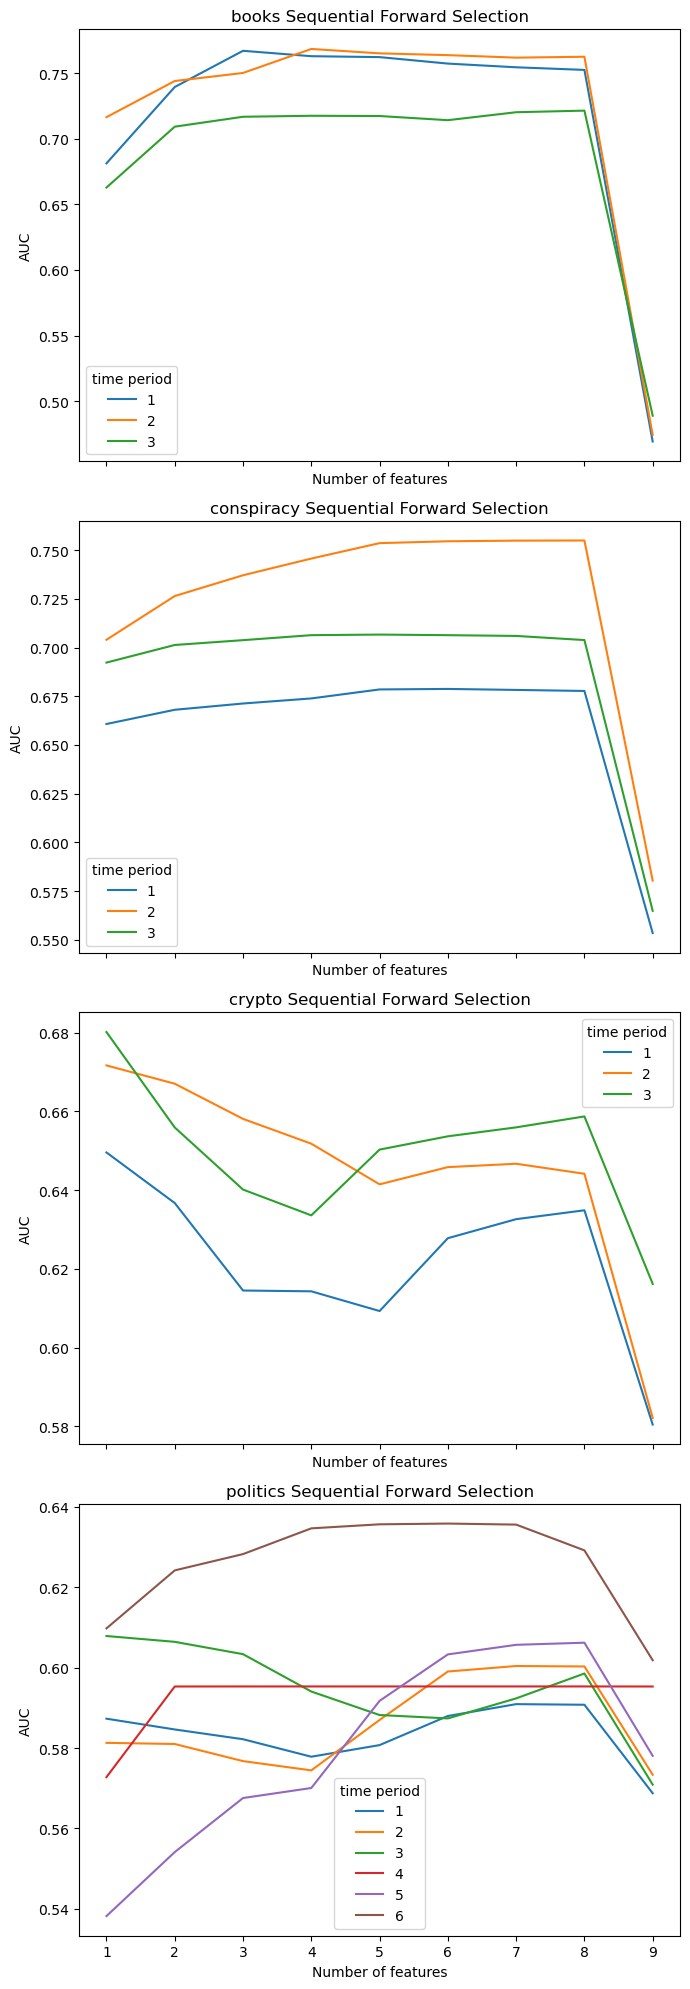

In [159]:
plot_num = 4
fig, axes = plt.subplots(plot_num,1, figsize=(7, plot_num*5), sharex=True)
i=0
for subreddit in FSS_metrics_dfs:
    for period in FSS_metrics_dfs[subreddit].index.unique():
        x = FSS_metrics_dfs[subreddit].loc[period, :].number_features
        y = FSS_metrics_dfs[subreddit].loc[period, :].avg_score
        axes[i].plot(x,y, label=period)
    axes[i].set_title(f'{subreddit} Sequential Forward Selection')
    axes[i].set_xlabel('Number of features')
    axes[i].set_ylabel('AUC')
    legend = axes[i].legend(title='time period')

    i += 1

fig.tight_layout()
plt.show()

In [163]:
with pd.ExcelWriter(FSS_outfile, engine='xlsxwriter') as writer:
    for subreddit in FSS_metrics_dfs:
        FSS_metrics_dfs[subreddit].to_excel(writer, sheet_name=subreddit)

In [165]:
pickle.dump(FSS_metrics_dfs, open(FSS_metrics_pickle_outfile, 'wb'))